# Identifikasi Masalah
## Latar Belakang
Dalam dunia akademik, artikel ilmiah diterbitkan setiap hari. Volume informasi ini menyulitkan akademisi baik itu mahasiswa, dosen, dan peneliti untuk mengikuti perkembangan terbaru secara menyeluruh. Disinilah penting nya topic modeling, dengan teknik ini, kita dapat secara otomatis mengelompokkan kumpulan abstrak artikel ilmiah ke dalam topik-topik utama seperti Artificial Intelligence, Cybersecurity, atau Computer Vision.

Topic modeling memungkinkan kita untuk:

- Mengidentifikasi tren penelitian yang sedang berkembang.
- Menemukan artikel relevan tanpa membaca satu per satu.
- Menyederhanakan eksplorasi literatur dalam jumlah besar.

Dalam tugas ini, kita akan membandingkan dua metode topic modeling:

- Latent Dirichlet Allocation (LDA).
- BERTopic.

Fokus tugas ini yaitu menilai model mana yang memberikan hasil pengelompokan topik yang lebih relevan, dapat dimengerti, dan sesuai dengan kategori asli artikel.

## Pertanyaan Penelitian
1. Topik apa saja yang berhasil ditemukan oleh masing-masing metode?

2. Berapa jumlah topik optimal, dan model mana yang memberikan skor kualitas topik terbaik?

3. Seberapa sesuai hasil topik dari masing-masing metode dengan label kategori asli dari artikel?



# Pengumpulan Dataset
## Sumber Data
Untuk tugas topic modeling ini, dataset yang digunakan adalah dataset publik "ArXiv Dataset" yang tersedia di platform Kaggle. Dataset ini berisi metadata dari jutaan publikasi ilmiah dari penerbit arXiv.org.

Setiap entri mencakup informasi seperti:
- id: ID unik artikel
- title: Judul artikel
- abstract: Ringkasan isi artikel (digunakan sebagai teks utama analisis)
- categories: Label bidang ilmu (misal: cs.AI, cs.CV, math.CO) yang akan digunakan untuk evaluasi model
- update_date: Tanggal terakhir artikel diperbarui

Dataset ini cocok dengan implementasi topic modeling karena berisi abstrak berkualitas tinggi, terstruktur, dan kaya informasi—ideal untuk pemrosesan bahasa alami (NLP).

Link Kaggle : https://www.kaggle.com/datasets/Cornell-University/arxiv

## Pengumpulan Data
Dataset asli berukuran besar (lebih dari 2 juta entri) dan disimpan dalam format JSON Lines (.jsonl), di mana setiap baris adalah satu objek JSON.

Supaya lebih relevan, dataset yang artikel yang digunakan hanya tahun 2021 keatas. Dari tahap ini, diperoleh DataFrame akhir (df_recent) dengan 1.055.586 baris. Karena keterbatasan komputasi, maka diambil sample sebanyak 100.00 saja.

In [ ]:
# Ini merupakan kode dari kaggle sendiri untuk mendownload dataset nya
import kagglehub

# Download latest version
path = kagglehub.dataset_download("Cornell-University/arxiv")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arxiv


In [ ]:
"""Kode ini digunakan untuk memindahkan file dataset yang telah ter download
kedalam direktori '/content/dataset' google colab"""
import shutil
# Source folder dari kagglehub
src_path = "/kaggle/input/arxiv"

# Target folder (direktori kerja biasa)
dst_path = "/content/dataset"

# Salin semua isi folder
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset telah dipindahkan ke:", dst_path)

Dataset telah dipindahkan ke: /content/dataset


In [ ]:
"""Kode dibawah digunakan untuk mengkonversi file dataset yang berformat json
ke dalam pandas dataframe, dan saat proses nya difilter hanya artikel atau paper
dengan tahun >= 2021"""

import pandas as pd
import json

data = []
file_path = '/content/dataset/arxiv-metadata-oai-snapshot.json'
start_year = 2021

with open(file_path, 'r') as f:
    for line in f:
        # Megubah setiap baris menjadi dictionary
        parsed_line = json.loads(line)

        # Membaca tahun dari kolom 'update_date'
        # try-except digunakan untuk antisipasi mana tau ada data yang aneh
        try:
            # Mendapatkan tahun dari kolom 'update date'
            year = int(parsed_line['update_date'][:4])

            # Simpa data >= 2021
            if year >= start_year:
                data.append(parsed_line)
        except (ValueError, TypeError):
            # Jika ada error maka dilanjutkan proses nya
            continue

# Membuat dataframe dari data-data yang sudah difilter
df = pd.DataFrame(data)

# Cek hasil dataframe
if not df.empty:
    print(f"Berhasil membaca {len(df)} baris data dari tahun {start_year} ke atas.")
    print("\nInformasi DataFrame:")
    df.info()

    print("\n5 baris pertama data terbaru:")
    print(df.head())
else:
    print(f"Tidak ada data yang ditemukan dari tahun {start_year} ke atas.")

Berhasil membaca 1055586 baris data dari tahun 2021 ke atas.

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055586 entries, 0 to 1055585
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1055586 non-null  object
 1   submitter       1055554 non-null  object
 2   authors         1055586 non-null  object
 3   title           1055586 non-null  object
 4   comments        673326 non-null   object
 5   journal-ref     208190 non-null   object
 6   doi             317727 non-null   object
 7   report-no       25292 non-null    object
 8   categories      1055586 non-null  object
 9   license         1054272 non-null  object
 10  abstract        1055586 non-null  object
 11  versions        1055586 non-null  object
 12  update_date     1055586 non-null  object
 13  authors_parsed  1055586 non-null  object
dtypes: object(14)
memory usage: 112.7+ MB

5 baris pertama data ter

In [ ]:
"""Kode pada cell ini berfungsi untuk mengambil 50.000 data dari dataset
Hal ini dilakukan karena dataset terlalu besar dan tidak cukup komputasi."""

sample_size = 50000

print(f"\nUkuran DataFrame asli: {len(df)} baris.")

# Menyimpan 50.000 data ke df_sampled
df_sampled = df.sample(n=sample_size, random_state=42)

print(f"Ukuran DataFrame setelah di-sample: {len(df_sampled)} baris.")

# Timpa df asli dengan df_sampled (tidak digunakan lagi)
df = df_sampled.copy()

# Reset index DataFrame yang sudah dilakukan proses sample
df.reset_index(drop=True, inplace=True)

# Cek jumlah baris
df.shape


Ukuran DataFrame asli: 1055586 baris.
Ukuran DataFrame setelah di-sample: 50000 baris.


(50000, 14)

# Pra-pemrosesan Teks (pre-processing)
Proses ini dilakukan sesuai dengan intruksi soal.

In [ ]:
# Kode dibawah adalah mendownload beberapa modul dari NLTK untu pre-processing teks
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
"""Kode ini digunakan untuk menggabungkan judul artikel dan abstrak menjadi
kolom teks untuk memperkaya informasi supaya LDA dan BertTopic lebih bisa
menangkap pola dan topik lebih baik"""

df['text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

In [ ]:
"""Kode dibawah didunakan untuk mendefinisikan fungsi pre-processing
yang akan diaplikasikan pada dataset"""

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
# Menggunakan stopwords berbahasa inggris karena dataset artikel berhasasa inggris
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Case Folding: Mengubah semua teks menjadi huruf kecil
    text = text.lower()

    # Filtering
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenisasi: Memecah teks menjadi token
    tokens = word_tokenize(text)

    # Stopword Removal & Lemmatization & Filtering kata pendek
    cleaned_tokens = []
    for word in tokens:
        # Cek apakah kata bukan stopword dan panjangnya lebih dari 2 huruf
        if word not in stop_words and len(word) > 2:
            # Lemmatization: Mengubah kata ke bentuk dasarnya
            cleaned_tokens.append(lemmatizer.lemmatize(word))

    return cleaned_tokens

In [ ]:
# Test hasil fungsi pre-processing yang telah dibuat
print("Hasil uji coba pra-pemrosesan pada 5 baris pertama:")
contoh_hasil = df['text'].head(5).apply(preprocess_text)
print(contoh_hasil)

Hasil uji coba pra-pemrosesan pada 5 baris pertama:
0    [morphological, computing, logic, underlying, ...
1    [sixteen, point, mathbbp, inverse, galois, pro...
2    [aibased, aortic, vessel, tree, segmentation, ...
3    [pathwise, unique, solution, stochastic, avera...
4    [twodimensional, stabilized, discontinuous, ga...
Name: text, dtype: object


In [ ]:
# Mengaplikasikan fungsi pada seluruh data di dataset dan disimpan pada kolom baru
df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Menampilkan dataset sebelum dan sesudah pre-processing
print(df[['text', 'processed_text']].sample(5))

                                                    text  \
43445  Laptop Theft in a University Setting can be Av...   
22744  A Riemannian Optimization Approach to Clusteri...   
23478  On sets where lip(f) is infinite for monotone ...   
40602  Geometrical Penrose Tilings are characterized ...   
5715   Classification of simply-transitive Levi non-d...   

                                          processed_text  
43445  [laptop, theft, university, setting, avoided, ...  
22744  [riemannian, optimization, approach, clusterin...  
23478  [set, lipf, infinite, monotone, continuous, fu...  
40602  [geometrical, penrose, tiling, characterized, ...  
5715   [classification, simplytransitive, levi, nonde...  


# Penerapan Algoritma Topic Modeling

## LDA
Penerapan algorima LDA pada tugas ini mengunakan library gensim, untuk dapat diaplikasikan pada LDA, kolom processed_text wajib diubah dalam bentuk dictionary lalu corpus. Saat mengkonversi kedalam dictionary, kata-kata dengan kemunculan kurang dari 15 dihapus dan jika muncul diatas 50% dari dokumen juga dihapus (dianggap umum), lalu setelah itu dijadikan corpus dengan metode BoW.

In [ ]:
!pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [ ]:
"""Kode cell ini berfungsi untuk membuat corpus dan dictionary, karena LDA
akan dijalankan dengan gensim yang membutuhkan corpus dan dictionary."""
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pandas as pd

documents = [doc for doc in df['processed_text'] if doc]

# Membuat Dictionary (memetakan setiap kata unik menjadi sebuah ID)
dictionary = Dictionary(documents)

# Memfilter kata eksrim, kata kuran dari 15 dan lebih dari 50% isi dokumen dihapus
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Membuat Corpus dengan Bag-of-Words
# BoW mengubah setiap dokumen menjadi representasi (ID kata, frekuensi)
corpus = [dictionary.doc2bow(doc) for doc in documents]

print(f"Jumlah kata unik dalam kamus setelah filtering: {len(dictionary)}")
print(f"Jumlah dokumen dalam corpus: {len(corpus)}")

Jumlah kata unik dalam kamus setelah filtering: 12554
Jumlah dokumen dalam corpus: 50000


In [ ]:
# Latih model LDA
# Jumah topik awal adalah 10
NUM_TOPICS = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    alpha='auto',
    eta='auto'
)

In [ ]:
# Menampilkan 10 kata kunci teratas untuk setiap topik
print("\nTopik yang ditemukan oleh LDA:")
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


Topik yang ditemukan oleh LDA:
(0, '0.017*"method" + 0.016*"model" + 0.015*"network" + 0.015*"algorithm" + 0.014*"learning" + 0.011*"data" + 0.010*"problem" + 0.009*"approach" + 0.007*"optimization" + 0.007*"proposed"')
(1, '0.013*"model" + 0.011*"system" + 0.009*"language" + 0.008*"data" + 0.006*"llm" + 0.006*"study" + 0.006*"research" + 0.006*"user" + 0.005*"paper" + 0.005*"analysis"')
(2, '0.015*"model" + 0.014*"field" + 0.011*"magnetic" + 0.009*"state" + 0.008*"energy" + 0.008*"theory" + 0.008*"phase" + 0.008*"spin" + 0.007*"transition" + 0.007*"effect"')
(3, '0.042*"space" + 0.041*"function" + 0.034*"operator" + 0.015*"game" + 0.012*"kernel" + 0.010*"map" + 0.010*"functional" + 0.008*"discrete" + 0.008*"transformation" + 0.008*"property"')
(4, '0.013*"graph" + 0.013*"result" + 0.013*"problem" + 0.011*"set" + 0.011*"number" + 0.010*"show" + 0.009*"bound" + 0.008*"prove" + 0.008*"paper" + 0.008*"matrix"')
(5, '0.026*"quantum" + 0.012*"state" + 0.011*"system" + 0.008*"material" + 0.

## BERTopic
Pada pemodelan BERTopic sedikit berbeda, BERTopic lebih cangih dalam menangkap semantik pada kata sehingga teks utuk lah yang akan diaplikasikan pada model ini. Model embedding yang digunakan adalah "all-MiniLM-L6-v2".

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch

# Menggunakan GPU T4 dari google colab
if torch.cuda.is_available():
    print("GPU terdeteksi!")
    print(f"Nama GPU: {torch.cuda.get_device_name(0)}")
    device = "cuda"
else:
    # Jika tidak, beri peringatan
    print("GPU tidak ditemukan.")
    device = "cpu"

GPU terdeteksi!
Nama GPU: Tesla T4


** Catatan **

Output dari sel training di bawah (progress bar) sengaja dihapus untuk agar file notebook dapat ditampilkan dengan benar pada GitHub. Proses training model berhasil.

In [ ]:
"""Kode dibawah adalah kode untuk melakukan pemodelan dengan BERTopic."""

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Pada tugas ini, model embedding yang digunakan adlaah "all-MiniLM-L6-v2"
embedding_model_name = "all-MiniLM-L6-v2"

# Memuat model ke GPU dengan SentenceTransformer
embedding_model = SentenceTransformer(embedding_model_name, device=device)

print(f"Embedding model '{embedding_model_name}' siap digunakan di {device}.")

# Inisiasi BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=True,
    verbose=True, #
    min_topic_size=50
)

# Mempersiapkan dokumen dari kolom 'text'
docs_for_bertopic = df['text'].tolist()

# Training model BERTopic
topics, probs = topic_model.fit_transform(docs_for_bertopic)

In [ ]:
# Menampilkan hasil BERTopic
print("\nRingkasan topik yang ditemukan oleh BERTopic:")
print(topic_model.get_topic_info())


Ringkasan topik yang ditemukan oleh BERTopic:
     Topic  Count                                               Name  \
0       -1  19966                                   -1_of_the_and_to   
1        0   7992                                   0_the_of_mass_in   
2        1   1218                             1_3d_pose_object_point   
3        2    960                                2_flow_the_of_fluid   
4        3    822                        3_channel_ris_wireless_mimo   
..     ...    ...                                                ...   
102    101     54  101_synchronization_oscillators_kuramoto_coupling   
103    102     53                102_domain_adaptation_target_source   
104    103     53     103_attention_transformers_transformer_pruning   
105    104     52              104_reaction_enzyme_chemical_networks   
106    105     51                 105_demand_routing_vehicle_problem   

                                        Representation  \
0        [of, the, and, to, in

# Evaluasi

Memulai perhitungan Coherence Score
Selesai menghitung untuk 5 topik.
Selesai menghitung untuk 10 topik.
Selesai menghitung untuk 15 topik.
Selesai menghitung untuk 20 topik.
Selesai menghitung untuk 25 topik.
Selesai menghitung untuk 30 topik.
Selesai menghitung untuk 35 topik.
Selesai menghitung untuk 40 topik.


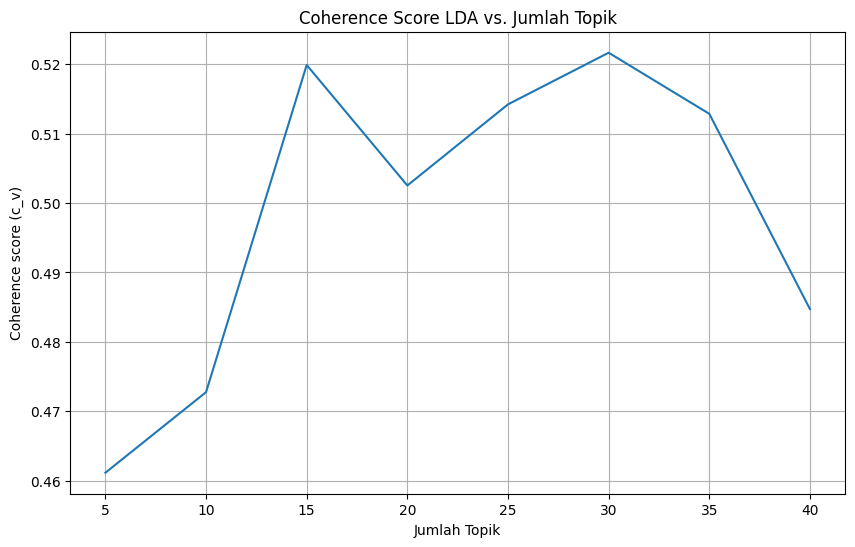


Jumlah topik optimal untuk LDA adalah: 30 dengan Coherence Score 0.5216


In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    #Menghitung skor koherensi untuk berbagai jumlah topik.
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42, passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Selesai menghitung untuk {num_topics} topik.")
    return model_list, coherence_values

# Menentukan rentang jumlah topik yang ingin diuji
# Uji dari 5 sampai 40 topik, dengan loncatan 5
start=5; limit=41; step=5;

print("Memulai perhitungan Coherence Score")
model_list_lda, coherence_values_lda = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=documents,
    start=start,
    limit=limit,
    step=step
)

# Visualisasi hasil
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values_lda)
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence score (c_v)")
plt.title("Coherence Score LDA vs. Jumlah Topik")
plt.xticks(x)
plt.grid(True)
plt.show()

# Mencari skor teritnggi
optimal_idx = coherence_values_lda.index(max(coherence_values_lda))
optimal_num_topics_lda = x[optimal_idx]
print(f"\nJumlah topik optimal untuk LDA adalah: {optimal_num_topics_lda} dengan Coherence Score {max(coherence_values_lda):.4f}")

In [ ]:
print("Ringkasan topik dari BERTopic:")
topic_info = topic_model.get_topic_info()
print(topic_info)

print(f"\nBERTopic secara otomatis menemukan {len(topic_info) - 1} topik (tidak termasuk topik -1/outliers).")

Ringkasan topik dari BERTopic:
     Topic  Count                                               Name  \
0       -1  19966                                   -1_of_the_and_to   
1        0   7992                                   0_the_of_mass_in   
2        1   1218                             1_3d_pose_object_point   
3        2    960                                2_flow_the_of_fluid   
4        3    822                        3_channel_ris_wireless_mimo   
..     ...    ...                                                ...   
102    101     54  101_synchronization_oscillators_kuramoto_coupling   
103    102     53                102_domain_adaptation_target_source   
104    103     53     103_attention_transformers_transformer_pruning   
105    104     52              104_reaction_enzyme_chemical_networks   
106    105     51                 105_demand_routing_vehicle_problem   

                                        Representation  \
0        [of, the, and, to, in, for, we, is, t

In [ ]:
# Kita gunakan jumlah topik optimal yang kita temukan dari grafik
OPTIMAL_NUM_TOPICS = 20

print(f"Melatih satu model LDA final dengan {OPTIMAL_NUM_TOPICS} topik...")

# Latih model LDA terbaik kita dengan parameter yang sama
best_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=OPTIMAL_NUM_TOPICS,
    random_state=42,       # Pastikan random_state sama untuk konsistensi
    passes=10,             # Jumlah iterasi training
    alpha='auto',
    eta='auto'
)

# Tampilkan 10 kata kunci teratas untuk setiap topik dari model terbaik
print("\nTopik yang ditemukan oleh model LDA terbaik (K=20):")
topics = best_lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

Melatih satu model LDA final dengan 20 topik...

Topik yang ditemukan oleh model LDA terbaik (K=20):
(0, '0.040*"model" + 0.029*"data" + 0.022*"method" + 0.016*"distribution" + 0.012*"prediction" + 0.010*"using" + 0.010*"approach" + 0.009*"learning" + 0.009*"estimation" + 0.008*"uncertainty"')
(1, '0.017*"system" + 0.017*"control" + 0.015*"learning" + 0.015*"user" + 0.014*"environment" + 0.013*"agent" + 0.012*"policy" + 0.009*"robot" + 0.008*"reinforcement" + 0.008*"framework"')
(2, '0.022*"phase" + 0.022*"field" + 0.021*"magnetic" + 0.016*"transition" + 0.014*"spin" + 0.013*"state" + 0.011*"symmetry" + 0.010*"topological" + 0.009*"lattice" + 0.009*"model"')
(3, '0.018*"space" + 0.016*"group" + 0.010*"result" + 0.009*"function" + 0.009*"show" + 0.009*"algebra" + 0.009*"prove" + 0.008*"class" + 0.007*"theorem" + 0.007*"also"')
(4, '0.039*"problem" + 0.032*"algorithm" + 0.014*"method" + 0.013*"optimization" + 0.013*"optimal" + 0.011*"bound" + 0.011*"function" + 0.009*"show" + 0.008*"matr

In [ ]:
# Lihat 15 topik teratas dari BERTopic (berdasarkan jumlah dokumen)
topic_info = topic_model.get_topic_info()
print(topic_info.head(15))

# Mari kita lihat isi dari beberapa topik teratas yang menarik
print("\nDetail untuk Topik 0:")
print(topic_model.get_topic(0))

print("\nDetail untuk Topik 2:")
print(topic_model.get_topic(2))

    Topic  Count                                   Name  \
0      -1  19966                       -1_of_the_and_to   
1       0   7992                       0_the_of_mass_in   
2       1   1218                 1_3d_pose_object_point   
3       2    960                    2_flow_the_of_fluid   
4       3    822            3_channel_ris_wireless_mimo   
5       4    755    4_segmentation_image_images_medical   
6       5    712        5_optical_photon_quantum_cavity   
7       6    661   6_quantum_circuits_classical_circuit   
8       7    583           7_speech_audio_speaker_music   
9       8    529    8_robot_robots_robotic_manipulation   
10      9    516        9_privacy_federated_fl_learning   
11     10    503  10_protein_molecular_learning_machine   
12     11    468     11_equation_solutions_omega_mathbb   
13     12    401     12_logic_semantics_automata_logics   
14     13    362      13_numerical_method_element_order   

                                       Representation  

In [ ]:
# Asumsi: df (50rb baris), best_lda_model (K=20), dan corpus sudah ada.

def get_dominant_topic(doc_bow):
    """
    Mendapatkan ID topik dengan probabilitas tertinggi untuk satu dokumen.
    """
    try:
        topic_dist = best_lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic = max(topic_dist, key=lambda x: x[1])
        return dominant_topic[0]
    except:
        # Jika dokumen kosong setelah preprocessing, kembalikan nilai null
        return None

# Pastikan panjang corpus dan df sesuai
if len(corpus) == len(df):
    print("Memproses setiap dokumen untuk menemukan topik dominannya dari LDA...")

    # Buat list berisi topik dominan untuk setiap dokumen
    lda_topics = [get_dominant_topic(doc) for doc in corpus]

    # Buat kolom baru di DataFrame
    df['lda_topic'] = lda_topics

    print("Selesai. Kolom 'lda_topic' berhasil ditambahkan.")

    # Verifikasi hasilnya:
    print("\nContoh hasil pelabelan topik LDA:")
    print(df[['text', 'lda_topic']].head())

    print("\nDistribusi dokumen per topik LDA:")
    print(df['lda_topic'].value_counts().sort_index())
else:
    print("Error: Panjang corpus LDA tidak sama dengan panjang DataFrame.")

Memproses setiap dokumen untuk menemukan topik dominannya dari LDA...
Selesai. Kolom 'lda_topic' berhasil ditambahkan.

Contoh hasil pelabelan topik LDA:
                                                text  lda_topic
0  Morphological Computing as Logic Underlying Co...         10
1  Sixteen points in $\mathbb{P}^4$ and the inver...          3
2  AI-based Aortic Vessel Tree Segmentation for C...          9
3  Pathwise unique solutions and stochastic avera...         14
4  A two-dimensional stabilized discontinuous Gal...          4

Distribusi dokumen per topik LDA:
lda_topic
0     3110
1     1990
2     3015
3     6189
4     3200
5     2057
6      517
7     1318
8     1225
9     3463
10    1571
11     336
12    7163
13    3217
14    3319
15    2248
16    2535
17    2608
18     881
19      38
Name: count, dtype: int64


In [ ]:
# Fungsi ini tidak berubah
def analyze_lda_topic(topic_id):
    """
    Menganalisis dan menampilkan komposisi kategori asli
    untuk sebuah topik dari LDA.
    """
    print(f"\n--- Menganalisis Topik LDA #{topic_id} ---")

    # Ambil kata kunci utama dari topik ini
    keywords = [word for word, _ in best_lda_model.show_topic(topic_id, topn=10)]
    print(f"Kata Kunci Topik: {keywords}")

    # Filter paper yang termasuk dalam topik ini
    papers_in_topic = df[df['lda_topic'] == topic_id]

    if papers_in_topic.empty:
        print("Tidak ada dokumen yang termasuk dalam topik ini.")
        return

    # Hitung frekuensi setiap kategori asli
    kategori_counts = papers_in_topic['categories'].str.split(' ').explode().value_counts()

    print("\n5 Kategori Asli Teratas dalam Topik ini:")
    print(kategori_counts.head(5))
    print("-"*(len(f"Menganalisis Topik LDA #{topic_id}") + 4))

# Analisis semua 20 topik dari LDA
print("\n" + "="*50)
print("ANALISIS VALIDASI EKSTERNAL UNTUK SETIAP TOPIK LDA")
print("="*50)

if 'lda_topic' in df.columns:
    for i in range(best_lda_model.num_topics):
        analyze_lda_topic(i)
else:
    print("Kolom 'lda_topic' belum ada. Jalankan kode di Langkah 1 terlebih dahulu.")


ANALISIS VALIDASI EKSTERNAL UNTUK SETIAP TOPIK LDA

--- Menganalisis Topik LDA #0 ---
Kata Kunci Topik: ['model', 'data', 'method', 'distribution', 'prediction', 'using', 'approach', 'learning', 'estimation', 'uncertainty']

5 Kategori Asli Teratas dalam Topik ini:
categories
cs.LG      1090
stat.ME     663
stat.ML     539
math.ST     314
stat.TH     314
Name: count, dtype: int64
-----------------------------

--- Menganalisis Topik LDA #1 ---
Kata Kunci Topik: ['system', 'control', 'learning', 'user', 'environment', 'agent', 'policy', 'robot', 'reinforcement', 'framework']

5 Kategori Asli Teratas dalam Topik ini:
categories
cs.RO      677
cs.LG      559
cs.AI      512
cs.SY      344
eess.SY    344
Name: count, dtype: int64
-----------------------------

--- Menganalisis Topik LDA #2 ---
Kata Kunci Topik: ['phase', 'field', 'magnetic', 'transition', 'spin', 'state', 'symmetry', 'topological', 'lattice', 'model']

5 Kategori Asli Teratas dalam Topik ini:
categories
cond-mat.str-el    